In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

In [33]:
# Define path
inspire_path = Path("/home/server/Projects/data/INSPIRE/physionet.org/files/inspire/1.3")
ops_path = inspire_path / "operations.csv"
labs_path = inspire_path / "labs.csv"

In [34]:
# Define dataframes
df = pd.read_csv(ops_path.as_posix())
df_lab = pd.read_csv(labs_path.as_posix())

In [35]:
# Variable definition

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur', 
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']


# find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)
df = df[(df['asa'] < 6)]
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

df['sex'] = df['sex'] == 'M'

In [36]:
# Splitting dataset into train and test
#print(df.astype({'inhosp_death_30day':int}).quantile([0, 0.25, 0.5, 0.75, 1]))
# Split a dataset into train and test sets
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)
y_train = df.loc[:ntrain, OUTCOME_VAR]
x_train = df.loc[:ntrain, INPUT_VARS].astype(float)
y_test = df.loc[ntrain:, OUTCOME_VAR]
x_test = df.loc[ntrain:, INPUT_VARS].astype(float)

# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

229/68103 (0.34%) train, 87/29187 (0.30%) test, 18 features


In [37]:
# ASA Model
# ASA class
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)

ASA auroc: 0.859, auprc: 0.105


In [38]:
# Logistic Regression Model
# Logistic regression using SimpleImputer()
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression()
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)

LR auroc: 0.949, auprc: 0.200


In [39]:
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=1)
dt_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_dt = dt_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_dt = roc_auc_score(y_test, y_pred_dt)
prc_dt, rec_dt, thresholds_dt = precision_recall_curve(y_test, y_pred_dt)
auprc_dt = auc(rec_dt, prc_dt)

print(f'DT auroc: {auroc_dt:.3f}, auprc: {auprc_dt:.3f}', flush=True)

DT auroc: 0.823, auprc: 0.098


In [40]:
# Gradient Boosting using XGBClassifier()
model = XGBClassifier(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss')
model.fit(x_train, y_train)
y_pred_gbm = model.predict_proba(x_test)[:, 1]

# Compute AUROC and AUPRC
auroc_gbm = roc_auc_score(y_test, y_pred_gbm)
prc_gbm, rec_gbm, thresholds = precision_recall_curve(y_test, y_pred_gbm)
auprc_gbm = auc(rec_gbm, prc_gbm)
print(f'GBM auroc: {auroc_gbm:.3f}, auprc: {auprc_gbm:.3f}', flush=True)

GBM auroc: 0.953, auprc: 0.205


In [41]:
# Create and train the Linear SVM model
svm_model = LinearSVC(max_iter=5000, random_state=1)
calibrated_svm_model = CalibratedClassifierCV(svm_model)  # Calibrate the model to get probability estimates
calibrated_svm_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_svm = calibrated_svm_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_svm = roc_auc_score(y_test, y_pred_svm)
prc_svm, rec_svm, thresholds_svm = precision_recall_curve(y_test, y_pred_svm)
auprc_svm = auc(rec_svm, prc_svm)

print(f'SVM auroc: {auroc_svm:.3f}, auprc: {auprc_svm:.3f}', flush=True)

SVM auroc: 0.948, auprc: 0.195


In [42]:
# Create and train the Kernel SVM model
kernel_svm_model = SVC(kernel='rbf', probability=True, max_iter=5000, random_state=1)
kernel_svm_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_kernel_svm = kernel_svm_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_kernel_svm = roc_auc_score(y_test, y_pred_kernel_svm)
prc_kernel_svm, rec_kernel_svm, thresholds_kernel_svm = precision_recall_curve(y_test, y_pred_kernel_svm)
auprc_kernel_svm = auc(rec_kernel_svm, prc_kernel_svm)

print(f'Kernel SVM auroc: {auroc_kernel_svm:.3f}, auprc: {auprc_kernel_svm:.3f}', flush=True)

/home/server/Projects/VitalDB-Dimensionality-Reduction/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Kernel SVM auroc: 0.496, auprc: 0.056


In [43]:
# Create and train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_nb = nb_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_nb = roc_auc_score(y_test, y_pred_nb)
prc_nb, rec_nb, thresholds_nb = precision_recall_curve(y_test, y_pred_nb)
auprc_nb = auc(rec_nb, prc_nb)

print(f'NB auroc: {auroc_nb:.3f}, auprc: {auprc_nb:.3f}', flush=True)

NB auroc: 0.941, auprc: 0.254


In [44]:
# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_knn = knn_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_knn = roc_auc_score(y_test, y_pred_knn)
prc_knn, rec_knn, thresholds_knn = precision_recall_curve(y_test, y_pred_knn)
auprc_knn = auc(rec_knn, prc_knn)

print(f'KNN auroc: {auroc_knn:.3f}, auprc: {auprc_knn:.3f}', flush=True)

KNN auroc: 0.605, auprc: 0.059


In [45]:
# Create and train the Balanced Bagging model
bb_model = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5, random_state=1), random_state=1)
bb_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_bb = bb_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_bb = roc_auc_score(y_test, y_pred_bb)
prc_bb, rec_bb, thresholds_bb = precision_recall_curve(y_test, y_pred_bb)
auprc_bb = auc(rec_bb, prc_bb)

print(f'Balanced Bagging auroc: {auroc_bb:.3f}, auprc: {auprc_bb:.3f}', flush=True)

Balanced Bagging auroc: 0.946, auprc: 0.106


In [46]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_rf = rf_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_rf = roc_auc_score(y_test, y_pred_rf)
prc_rf, rec_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
auprc_rf = auc(rec_rf, prc_rf)

print(f'RF auroc: {auroc_rf:.3f}, auprc: {auprc_rf:.3f}', flush=True)

RF auroc: 0.949, auprc: 0.238


In [47]:
# Define base models
base_models = [
    ('lr', LogisticRegression(max_iter=5000)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=1)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('nb', GaussianNB()),
    ('svm', CalibratedClassifierCV(LinearSVC(max_iter=5000, random_state=1))),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)),
    ('bb', BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5, random_state=1), random_state=1)),
    ('gbm', XGBClassifier(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss'))
]

# Define meta-model
meta_model = LogisticRegression(max_iter=5000)

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train stacking model
stacking_model.fit(x_train_imputed, y_train)

# Predict probabilities for the test set
y_pred_stacking = stacking_model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_stacking = roc_auc_score(y_test, y_pred_stacking)
prc_stacking, rec_stacking, thresholds_stacking = precision_recall_curve(y_test, y_pred_stacking)
auprc_stacking = auc(rec_stacking, prc_stacking)

print(f'Stacking auroc: {auroc_stacking:.3f}, auprc: {auprc_stacking:.3f}', flush=True)

Stacking auroc: 0.955, auprc: 0.233


ASA auroc: 0.859, auprc: 0.105
LR auroc: 0.949, auprc: 0.200
GBM auroc: 0.953, auprc: 0.205
DT auroc: 0.823, auprc: 0.098
SVM auroc: 0.948, auprc: 0.195
Kernel SVM auroc: 0.496, auprc: 0.056
NB auroc: 0.941, auprc: 0.254
KNN auroc: 0.605, auprc: 0.059
Balanced Bagging auroc: 0.946, auprc: 0.106
RF auroc: 0.949, auprc: 0.238
Stacking auroc: 0.955, auprc: 0.233


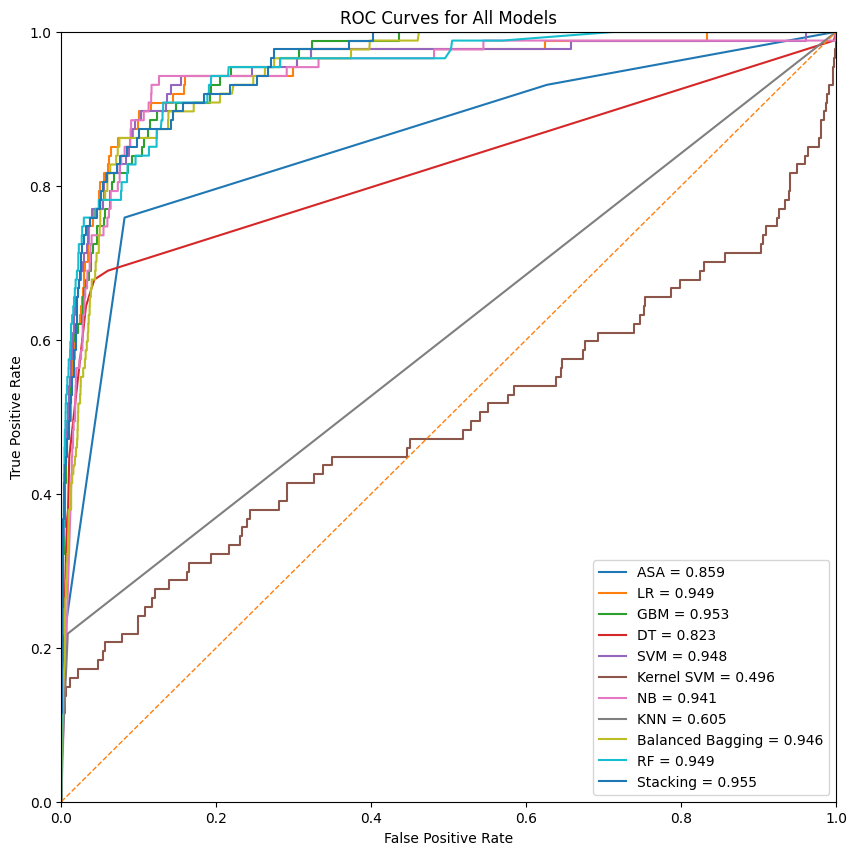

In [50]:
# Final Graph and Results

# Compute ROC curves
fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
fpr_kernel_svm, tpr_kernel_svm, _ = roc_curve(y_test, y_pred_kernel_svm)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
fpr_bb, tpr_bb, _ = roc_curve(y_test, y_pred_bb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_pred_stacking)

# Plot ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr_asa, tpr_asa, label='ASA = {:0.3f}'.format(auroc_asa))
plt.plot(fpr_lr, tpr_lr, label='LR = {:0.3f}'.format(auroc_lr))
plt.plot(fpr_gbm, tpr_gbm, label='GBM = {:0.3f}'.format(auroc_gbm))
plt.plot(fpr_dt, tpr_dt, label='DT = {:0.3f}'.format(auroc_dt))
plt.plot(fpr_svm, tpr_svm, label='SVM = {:0.3f}'.format(auroc_svm))
plt.plot(fpr_kernel_svm, tpr_kernel_svm, label='Kernel SVM = {:0.3f}'.format(auroc_kernel_svm))
plt.plot(fpr_nb, tpr_nb, label='NB = {:0.3f}'.format(auroc_nb))
plt.plot(fpr_knn, tpr_knn, label='KNN = {:0.3f}'.format(auroc_knn))
plt.plot(fpr_bb, tpr_bb, label='Balanced Bagging = {:0.3f}'.format(auroc_bb))
plt.plot(fpr_rf, tpr_rf, label='RF = {:0.3f}'.format(auroc_rf))
plt.plot(fpr_stacking, tpr_stacking, label='Stacking = {:0.3f}'.format(auroc_stacking))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.savefig('auroc_all_models.png')
#plt.show()

# Print results
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(f'GBM auroc: {auroc_gbm:.3f}, auprc: {auprc_gbm:.3f}', flush=True)
print(f'DT auroc: {auroc_dt:.3f}, auprc: {auprc_dt:.3f}', flush=True)
print(f'SVM auroc: {auroc_svm:.3f}, auprc: {auprc_svm:.3f}', flush=True)
print(f'Kernel SVM auroc: {auroc_kernel_svm:.3f}, auprc: {auprc_kernel_svm:.3f}', flush=True)
print(f'NB auroc: {auroc_nb:.3f}, auprc: {auprc_nb:.3f}', flush=True)
print(f'KNN auroc: {auroc_knn:.3f}, auprc: {auprc_knn:.3f}', flush=True)
print(f'Balanced Bagging auroc: {auroc_bb:.3f}, auprc: {auprc_bb:.3f}', flush=True)
print(f'RF auroc: {auroc_rf:.3f}, auprc: {auprc_rf:.3f}', flush=True)
print(f'Stacking auroc: {auroc_stacking:.3f}, auprc: {auprc_stacking:.3f}', flush=True)

ASA auroc: 0.859, auprc: 0.105
LR auroc: 0.949, auprc: 0.200
GBM auroc: 0.953, auprc: 0.205


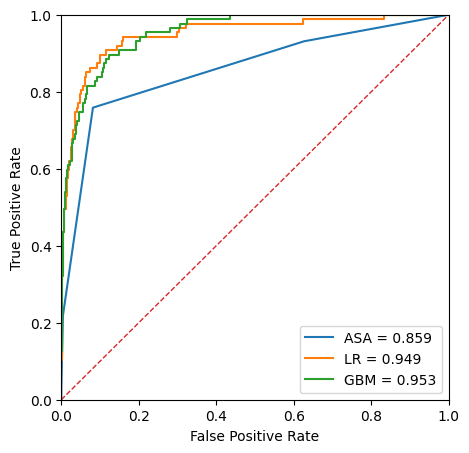

In [49]:
# Final Graph and Results

fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)

plt.figure(figsize=(5,5))
plt.plot(fpr_asa, tpr_asa, label='ASA = {:0.3f}'.format(auroc_asa))
plt.plot(fpr_lr, tpr_lr, label='LR = {:0.3f}'.format(auroc_lr))
plt.plot(fpr_gbm, tpr_gbm, label='GBM = {:0.3f}'.format(auroc_gbm))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('auroc.png')
#plt.show()

#print results
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(f'GBM auroc: {auroc_gbm:.3f}, auprc: {auprc_gbm:.3f}', flush=True)